In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esn.esn import DeepESN, DeepSubreservoirESN
from esn import activation as A
from esn.initialization import *
from scipy.integrate import odeint
import torch
np.random.seed(42)

In [2]:
device = torch.device('cpu')
dtype = torch.double
torch.set_default_dtype(dtype)

In [3]:
pat_2 = pd.read_csv('data/abc_pat_2.csv')
pat_8 = pd.read_csv('data/abc_pat_8.csv')
pat_17 = pd.read_csv('data/abc_pat_17.csv')

,Unnamed: 0,t,mtd,C,P,Q,Qp
42,42,-4.759712,161.679987,0.000000,43.304128,118.375860,0.000000
43,43,-4.659712,162.445502,0.000000,43.238777,119.206726,0.000000
44,44,-4.559712,163.205472,0.000000,43.169176,120.036296,0.000000
45,45,-4.459712,163.959868,0.000000,43.095378,120.864490,0.000000
46,46,-4.359712,164.708664,0.000000,43.017438,121.691227,0.000000
...,...,...,...,...,...,...,...
203,203,11.400000,162.720206,0.889094,12.529912,135.366250,14.824044
204,204,11.500000,162.351636,0.888177,12.451005,135.105948,14.794683
205,205,11.600000,161.983811,0.887262,12.373289,134.845619,14.764902
206,206,11.700000,161.616751,0.886347,12.296748,134.585284,14.734719


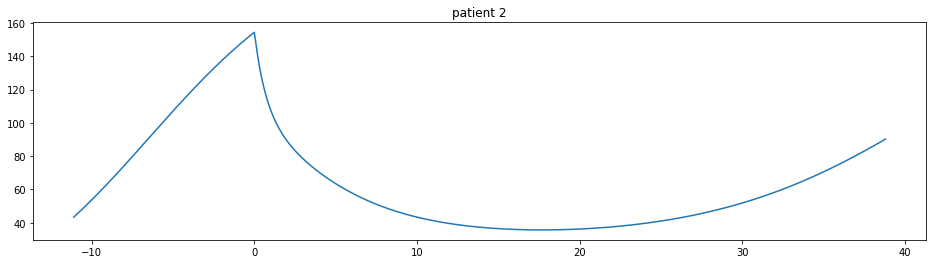

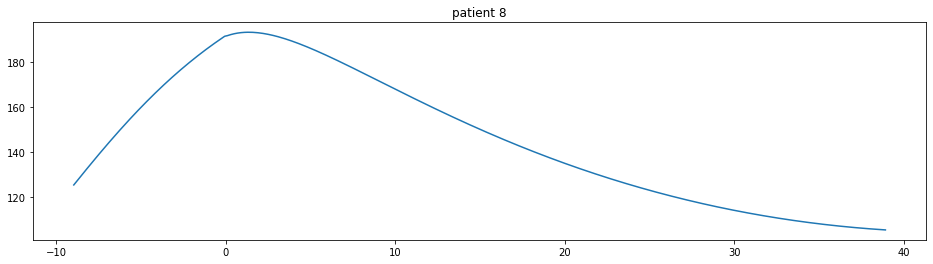

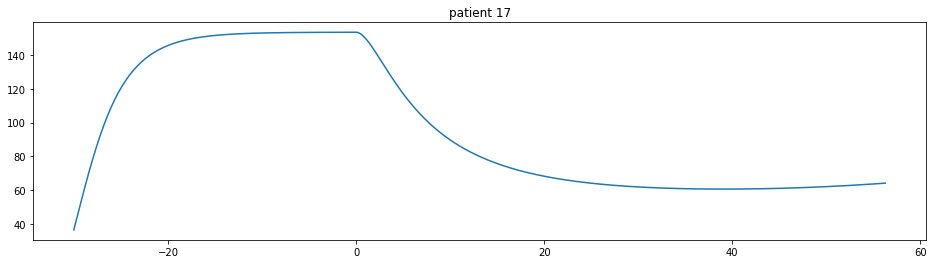

In [4]:
for pat, title in [(pat_2, 'patient 2'), (pat_8, 'patient 8'), (pat_17, 'patient 17')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(pat.t, pat.mtd)
    plt.show()

In [153]:
def data_for_patient(pat, start_train=0, div=0.7):
    data = pat[(pat.t >= start_train)]['mtd'].to_numpy()
    trainingLength = int(len(data) * div)
    print(data[:-1].shape)
    X = data[:-1].reshape((-1, 1, 1))
    print(X.shape)
    X = torch.from_numpy(X).to(device)
    y = data[1:].reshape((-1, 1, 1))
    y = torch.from_numpy(y).to(device)
    return X[:-trainingLength], X[-trainingLength:], y[:-trainingLength], y[-trainingLength:]

In [144]:
def experiment(pat, start_train=0, transient=20, hidden_size=1000):
    X, X_test, y, y_test = data_for_patient(pat, start_train)
    t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    esn = DeepESN(1, hidden_size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(), transient=transient)
    esn.fit(X, y)
    pred = esn(X_test)
    y_pred = pred.view(-1).detach().numpy()
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.plot(pat.t, pat.mtd, label='test')
    ax.plot(t_test, y_pred, label='prediction')
    ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
    plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

In [154]:
X, X_test, y, y_test = data_for_patient(pat_8, 0)
t_test = pat[pat.t >= 0].iloc[len(y) + 1:].t

(388,)
(388, 1, 1)


In [152]:
type(X)

torch.Tensor

In [141]:
for transient in range(10, 120, 10):
#     transient = 50
    size = 1000
    esn = DeepESN(1, size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(), transient=transient)
    esn.fit(X, y)
    pred = esn(X_test)
    print(transient, mean_squared_error(y_test.view(-1).detach().numpy(), pred.view(-1).detach().numpy()))    

10 8.649600964896382e-06
20 9.843815442057127e-06
30 9.870932053183303e-06
40 1.7017320593558357e-05
50 3.420482565132322e-05
60 3.538930163346818e-05
70 5.774649955202447e-05
80 9.339995732223283e-05
90 0.0001376606259286914
100 0.0002732966052087832
110 0.00605627530209506


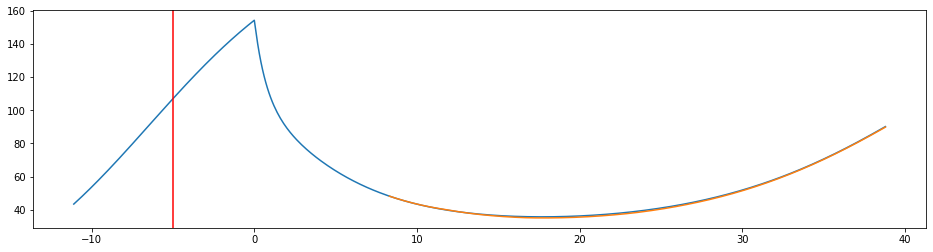

In [150]:
experiment(pat_2, -5)

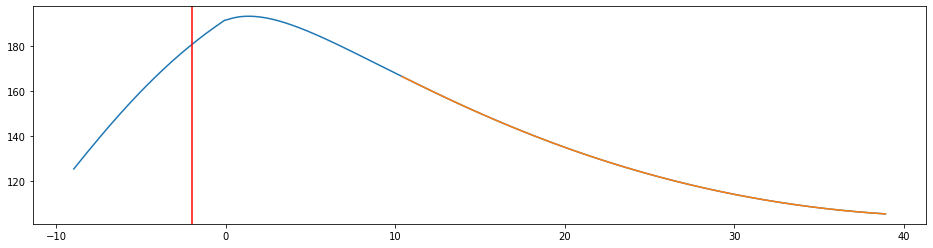

In [149]:
experiment(pat_8, -2)

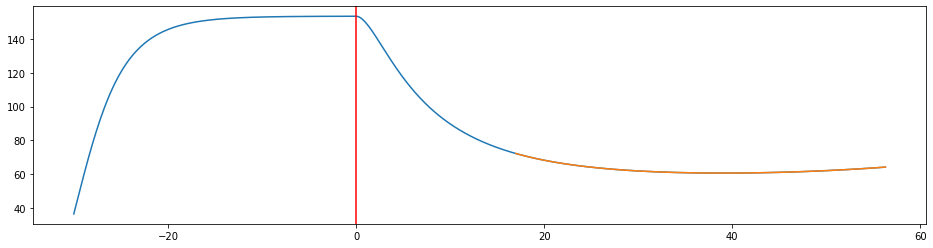

In [147]:
experiment(pat_17, 0, hidden_size=120)